In [1]:
# Importar as bibliotecas

import seaborn as sns
import pandas as pd
from tqdm.notebook import tqdm

## Lendo o dataset

In [2]:
df0 = pd.read_csv('Bitcoin_tweets.csv')
df0.info()

/home/ffreller/.conda/envs/teste1/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3417: DtypeWarning: Columns (4,5,6,7,12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2830476 entries, 0 to 2830475
Data columns (total 13 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   user_name         object
 1   user_location     object
 2   user_description  object
 3   user_created      object
 4   user_followers    object
 5   user_friends      object
 6   user_favourites   object
 7   user_verified     object
 8   date              object
 9   text              object
 10  hashtags          object
 11  source            object
 12  is_retweet        object
dtypes: object(13)
memory usage: 280.7+ MB


In [3]:
df0.columns

Index(['user_name', 'user_location', 'user_description', 'user_created',
       'user_followers', 'user_friends', 'user_favourites', 'user_verified',
       'date', 'text', 'hashtags', 'source', 'is_retweet'],
      dtype='object')

In [4]:
df0.head(5)

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
0,DeSota Wilson,"Atlanta, GA","Biz Consultant, real estate, fintech, startups...",2009-04-26 20:05:09,8534.0,7605,4838,False,2021-02-10 23:59:04,Blue Ridge Bank shares halted by NYSE after #b...,['bitcoin'],Twitter Web App,False
1,CryptoND,NaN,😎 BITCOINLIVE is a Dutch platform aimed at inf...,2019-10-17 20:12:10,6769.0,1532,25483,False,2021-02-10 23:58:48,"😎 Today, that's this #Thursday, we will do a ""...","['Thursday', 'Btc', 'wallet', 'security']",Twitter for Android,False
2,Tdlmatias,"London, England","IM Academy : The best #forex, #SelfEducation, ...",2014-11-10 10:50:37,128.0,332,924,False,2021-02-10 23:54:48,"Guys evening, I have read this article about B...",NaN,Twitter Web App,False
3,Crypto is the future,NaN,I will post a lot of buying signals for BTC tr...,2019-09-28 16:48:12,625.0,129,14,False,2021-02-10 23:54:33,$BTC A big chance in a billion! Price: \487264...,"['Bitcoin', 'FX', 'BTC', 'crypto']",dlvr.it,False
4,Alex Kirchmaier 🇦🇹🇸🇪 #FactsSuperspreader,Europa,Co-founder @RENJERJerky | Forbes 30Under30 | I...,2016-02-03 13:15:55,1249.0,1472,10482,False,2021-02-10 23:54:06,This network is secured by 9 508 nodes as of t...,['BTC'],Twitter Web App,False


Como o objetivo deste notebook é analisar o perfil dos usuário (e não seus tweets), vamos analisar as colunas referente ao usuário: user_name, user_location, user_description, user_followers, user_favourites, user_friends, user_verified. Apesar de ser referente ao tweet, também analisaremos a coluna source, já que ela pode fornecer alguma informação sobre o usuário

## Tratar colunas

In [5]:
## Corrigindo colunas de data
df0['date'] = pd.to_datetime(df0['date'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
df0['user_created'] = pd.to_datetime(df0['user_created'], format='%Y-%m-%d %H:%M:%S', errors='coerce')

In [6]:
## Corrigindo user_verified
df0['user_verified'] = df0['user_verified'].apply(lambda x: (True if x=='True' else False) if type(x)==str else x).astype(bool)

In [7]:
# Limpar colunas numéricas
def clean_number_column(value):
    try:
        return float(value)
    except:
        return float("NaN")

df0['user_favourites'] = df0['user_favourites'].apply(clean_number_column)
df0['user_friends'] = df0['user_friends'].apply(clean_number_column)
df0['user_followers'] = df0['user_followers'].apply(clean_number_column)

## Agrupar dados

Vamos agrupar o dataset por usuário, para que possamos olhar para suas características independentemente do número de tweets de cada usuário. Como não há um id único para cada um, vamos agrupá-los usando a combinação nome+user_created

In [8]:
group_dict = {
    'user_description':'last',
    'user_created':'min',
    'user_followers':'mean',
    'user_friends':'mean',
    'user_favourites':'mean',
    'user_verified':'max',
    'date':'count',
    'user_name':'last',
}
df_ = df0.sort_values('date').copy()
df_['id'] = df_['user_name'] + df_['user_created'].astype(str)
df1 = df_.groupby('id').agg(group_dict)
df1.rename(columns={'date':'tweet_count'}, inplace=True)

In [9]:
# Para user_location, vamos criar um agrupador que traz a última localização que o usuário preencheu
def last_if_not_nan(values):
    for i in range(len(values)-1, -1, -1):
        value = values.iloc[i]
        if (str(value).lower() != 'nan') and (value != '') and (value != None) and (pd.isna(value) == False):
            return value
    return 'NaN'

df2 = df_[['id', 'user_location']].groupby('id').agg(last_if_not_nan)
df1['user_location'] = df2['user_location'].copy()

In [10]:
del df_, df2

## Analisar colunas

### user_verfified

In [11]:
print(f"{df1['user_verified'].mean():.3%} dos usuários são verificados")

0.692% dos usuários são verificados


### Date e user_created

In [12]:
print(f"Data do tweet mais recente: {df0['date'].max():%d/%m/%Y}")
print(f"Data do tweet mais antigo: {df0['date'].min():%d/%m/%Y}")

Data do tweet mais recente: 16/04/2022
Data do tweet mais antigo: 05/02/2021


O dataset vai de 5 de fevereiro de 2021 até 16 de abril de 2022

In [13]:
df1['user_created'].dt.year.value_counts(1).sort_index().map('{:.2%}'.format)

1970.0     0.00%
2006.0     0.01%
2007.0     0.24%
2008.0     0.86%
2009.0     4.69%
2010.0     3.44%
2011.0     4.26%
2012.0     3.79%
2013.0     3.38%
2014.0     3.19%
2015.0     2.90%
2016.0     2.88%
2017.0     4.39%
2018.0     4.93%
2019.0     5.80%
2020.0    12.54%
2021.0    37.82%
2022.0     4.90%
Name: user_created, dtype: object

In [14]:
print("Número de usuários criados antes de 2006, data em que o twitter foi criado:", len(df1[df1['user_created'].dt.year < 2006]))

Número de usuários criados antes de 2006, data em que o twitter foi criado: 3


A maioria dos usuários foi criada recentement -mais da metade deles entre 2019 e 2022. Há 3 datas de criação no ano 1970, o que só pode ser explicado por maus registros, já que não existia Twitter neste ano

<AxesSubplot:>

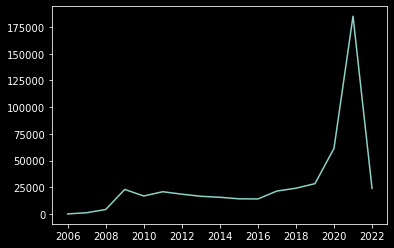

In [15]:
df1.loc[df1['user_created'].dt.year < 2006, 'user_created'] = pd.to_datetime('2009-01-01')
date_created_counts = df1['user_created'].dt.year.value_counts()
sns.lineplot(x=date_created_counts.index, y=date_created_counts.values)

### source

In [16]:
## 10 fontes mais comuns no dataset e sua porcentagem no dataset
df0['source'].value_counts(1).head(10).map('{:.2%}'.format)

Twitter for Android    30.07%
Twitter Web App        25.77%
Twitter for iPhone     19.18%
IFTTT                   1.50%
dlvr.it                 1.15%
TweetDeck               0.78%
ContentStudio.io        0.76%
Twitter for iPad        0.61%
HoBaBot                 0.46%
Hootsuite Inc.          0.42%
Name: source, dtype: object

Nota-se que android+iphone representam quase 50% das fontes de todos os tweets

In [17]:
top_10 = df0['source'].value_counts().head(10).index
# Transformando valores que não estão no top10 em "outros"
df0.loc[~df0['source'].isin(top_10), 'source'] = 'outros'
df0['source'] = pd.Categorical(df0['source'])
df0['source'].value_counts(1).map('{:.2%}'.format)

Twitter for Android    30.03%
Twitter Web App        25.74%
outros                 19.39%
Twitter for iPhone     19.16%
IFTTT                   1.50%
dlvr.it                 1.15%
TweetDeck               0.78%
ContentStudio.io        0.76%
Twitter for iPad        0.61%
HoBaBot                 0.46%
Hootsuite Inc.          0.42%
Name: source, dtype: object

Fontes que não estão no top 10 representam 19% das fontes do dataset. Usuários, portanto, usam diversas fontes para publicar, mas as principais são via aparelho móvel

### user_favourites

In [18]:
df1['user_favourites'].describe().apply("{0:.2f}".format)

count     489613.00
mean        5226.87
std        18431.21
min            0.00
25%           90.00
50%          586.33
75%         3021.50
max      1248517.00
Name: user_favourites, dtype: object

Os usuários têm uma média de 5226 favoritos. Mas, olhando pra mediana (586), percebe-se que a distribuição é assimétrica positivamente -ou seja, usuários com muitos favoritos estão puxando a média pra cima.

In [19]:
#Retirando outliers para olhar melhor para o coluna
iqr = df1['user_favourites'].quantile(0.75) - df1['user_favourites'].quantile(0.25)
upper_limit = df1['user_favourites'].quantile(0.75) + iqr*3
df1.loc[df1['user_favourites']>upper_limit, 'user_favourites'] = upper_limit

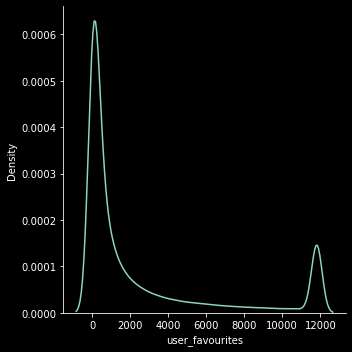

In [20]:
sns.displot(data=df1, x='user_favourites', kind='kde')

### user_friends

In [21]:
df1['user_friends'].describe().apply("{0:.2f}".format)

count     489612.00
mean         732.77
std         9139.72
min            0.00
25%           74.00
50%          236.00
75%          670.50
max      4199947.67
Name: user_friends, dtype: object

Assim como no caso dos favoritos, a média (732) é bem maior que a mediana (236). Isso significa que a distribuição é assimétrica positivamente.

In [22]:
#Retirando outliers para olhar melhor para o coluna
iqr = df1['user_friends'].quantile(0.75) - df1['user_friends'].quantile(0.25)
upper_limit = df1['user_friends'].quantile(0.75) + iqr*3
df1.loc[df1['user_friends']>upper_limit, 'user_friends'] = upper_limit

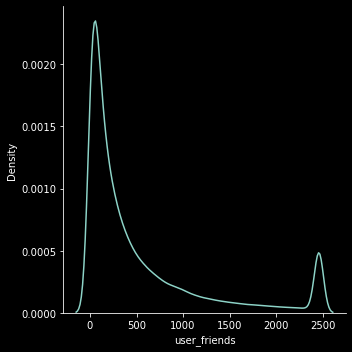

In [23]:
sns.displot(data=df1, x='user_friends', kind='kde')

### user_followers

In [24]:
df1['user_followers'].describe().apply("{0:.2f}".format)

count      489626.00
mean         2926.19
std         76625.21
min             0.00
25%            15.00
50%            75.50
75%           371.75
max      23770586.00
Name: user_followers, dtype: object

Assim como as outras duas variáveis numéricas, temos uma distribuição positivamente assimétrica. Usuários têm média de 2926 seguidores, mas mediana de 76

In [25]:
#Retirando outliers para olhar melhor para o coluna
iqr = df1['user_followers'].quantile(0.75) - df1['user_friends'].quantile(0.25)
upper_limit = df1['user_followers'].quantile(0.75) + iqr*3
df1.loc[df1['user_followers']>upper_limit, 'user_followers'] = upper_limit

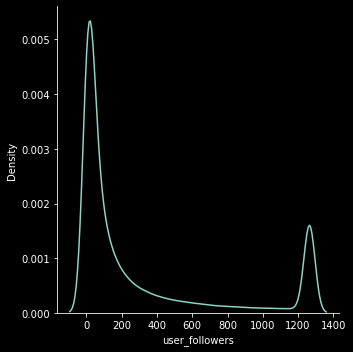

In [26]:
sns.displot(data=df1, x='user_followers', kind='kde')

### user_name
Vamos ver se conseguimos extrair informações sobre os usuários a partir de seus nomes

In [27]:
keywords_crypto = ['bitcoin', 'cr(?:y|i)pto', 'ethereum']
for word in keywords_crypto:
    df1[f'{word}_in_name'] = df1['user_name'].str.lower().str.contains(word)

In [28]:
for word in keywords_crypto:
    print(word)
    media = df1[f'{word}_in_name'].mean()
    print(f"{media:.3%} dos usuários têm referência ao termo '{word}' em seu nome")
    print()

bitcoin
1.143% dos usuários têm referência ao termo 'bitcoin' em seu nome

cr(?:y|i)pto
6.881% dos usuários têm referência ao termo 'cr(?:y|i)pto' em seu nome

ethereum
0.033% dos usuários têm referência ao termo 'ethereum' em seu nome



Vemos que uma parte relevante dos usuários que tuíta sobre bitcoin está ligado ao tema das criptomoedas. 

ps: 'cr(?:y|i)pto' é uma expressão regular para que tanto crypto quanto cripto atendam ao critério.

In [29]:
df1['any_crypto_in_name'] = df1[[w+'_in_name' for w in keywords_crypto]].any(axis=1)
print(f"{df1['any_crypto_in_name'].mean():.3%} dos usuários têm referência a uma das palavras chaves relacionadas a criptomoedas (bitcoin, cripto, ethereum) em seu nome")

8.018% dos usuários têm referência a uma das palavras chaves relacionadas a criptomoedas (bitcoin, cripto, ethereum) em seu nome


8% têm pelo menos uma das palavras-chave selecionadas no nome

### user_description

In [30]:
for word in keywords_crypto:
    df1[f'{word}_in_description'] = df1['user_description'].str.lower().str.contains(word)

In [31]:
for word in keywords_crypto:
    print(word)
    media = df1[f'{word}_in_description'].mean()
    print(f"{media:.3%} dos usuários têm referência ao termo '{word}' em sua descrição")
    print()

bitcoin
15.315% dos usuários têm referência ao termo 'bitcoin' em sua descrição

cr(?:y|i)pto
22.499% dos usuários têm referência ao termo 'cr(?:y|i)pto' em sua descrição

ethereum
1.364% dos usuários têm referência ao termo 'ethereum' em sua descrição



As descrições dos usuários também indiam que os tweets sobre bitcoin costumam vir de pessoas que têm relação consolidada com o tema das criptomoedas

In [32]:
df1['any_crypto_in_description'] = df1[[w+'_in_description' for w in keywords_crypto]].any(axis=1)
print(f"{df1['any_crypto_in_description'].mean():.3%} dos usuários têm referência a uma das palavras chaves relacionadas a criptomoedas (bitcoin, cripto, ethereum) na sua descrição")

28.009% dos usuários têm referência a uma das palavras chaves relacionadas a criptomoedas (bitcoin, cripto, ethereum) na sua descrição


In [33]:
df1['any_crypto_in_name_description'] = df1[['any_crypto_in_description', 'any_crypto_in_name']].any(axis=1)
print(f"{df1['any_crypto_in_name_description'].mean():.3%} dos usuários têm referência a uma das palavras chaves relacionadas a criptomoedas (bitcoin, cripto, ethereum) em seu nome ou descrição")

30.724% dos usuários têm referência a uma das palavras chaves relacionadas a criptomoedas (bitcoin, cripto, ethereum) em seu nome ou descrição


Considerando o nome do usuário e a descrição, quase um terço (30%) dos autores de tweets sobre bitcoin trazem alguma palavra relacionada a criptomoedas em seu perfil. Isso nos indica mais uma vez que os tweets sobre bitcoin são produzidos, em larga escala, por usuários realmente ligados ao tema.

### Contagem de postagens por usuário

In [34]:
df1['tweet_count'].describe()

count    489707.000000
mean          5.779562
std          67.129778
min           0.000000
25%           1.000000
50%           1.000000
75%           3.000000
max       13137.000000
Name: tweet_count, dtype: float64

Aqui temos de novo uma média maior que a mediana, o que indica uma distriubuição assimétrica positivamente. Chama atenção que a mediana seja 1, o que significa que a maioria dos usuários têm apenas um tweet sobre o assunto. Ou seja, essa informação nos indica que há também um grande número de usuários que fala sobre bitcoin de maneira mais casual

In [35]:
#Retirando outliers para olhar melhor para o coluna
upper_limit = df1['tweet_count'].quantile(0.99)
df1.loc[df1['tweet_count']>upper_limit, 'tweet_count'] = upper_limit

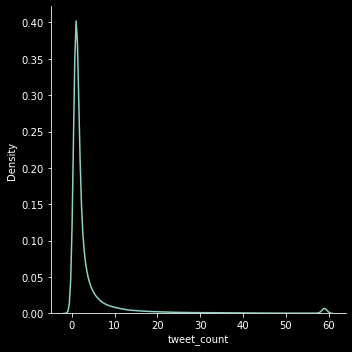

In [36]:
sns.displot(data=df1, x='tweet_count', kind='kde')

### user_location

In [37]:
## Geographic python imports

from geotext import GeoText
from geopy.geocoders import Nominatim
from folium.plugins import FastMarkerCluster, MarkerCluster
import folium

In [38]:
## Helper functions

geolocator = Nominatim(user_agent='f', timeout=3)
def get_lat_lon(string):
    info =  geolocator.geocode(string)
    try:
        return pd.Series([info.latitude, info.longitude])
    except:
        return (0,0)

def get_country(string):
    list_of_countries = GeoText(str(string)).countries
    if len(list_of_countries) > 0:
        return list_of_countries[0]
    return ''

def get_city(string):
    list_of_cities = GeoText(str(string)).cities
    if len(list_of_cities) > 0:
        return list_of_cities[0]
    return ''

def get_country_or_city(string):
    gtxt = GeoText(str(string))
    list_of_countries = gtxt.countries
    if len(list_of_countries) > 0:
        return list_of_countries[0]
    
    list_of_cities = gtxt.cities
    if len(list_of_cities) > 0:
        return list_of_cities[0]
    return ''

In [39]:
locations = df1['user_location'].unique()
print(len(locations), 'localizações diferentes no dataset')

69804

In [40]:
location_country = {loc: get_country(loc) for loc in locations}
location_city = {loc: get_city(loc) for loc in locations}
location_country_or_city = {loc: get_country_or_city(loc) for loc in locations}

In [41]:
df1['country'] = df1['user_location'].map(location_country)
df1['city'] = df1['user_location'].map(location_city)
df1['country_or_city'] = df1['user_location'].map(location_country_or_city)

In [42]:
print(f"Usuáruios sem país: {(df1['country'] == '').mean():.2%}")
print(f"Usuáruios sem cidade: {(df1['city'] == '').mean():.2%}")
print(f"Usuáruios sem país ou cidade: {(df1['country_or_city'] == '').mean():.2%}")

Usuáruios sem país: 86.11%
Usuáruios sem cidade: 81.79%
Usuáruios sem país ou cidade: 72.20%


Em 72% dos usuários, não foi possível extrai sua localização do campo user_location. As análises sobre localização, portanto, vão focar nos restantes 28% dos usuários

Vamos olhar para a frequência de presença de cada local. Para isso, vamos excluir usuáriod cuja localização não pudemos determinar. Assim, pode-se olhar melhor para a distribuição dos usuário pelo mundo

In [43]:
# 10 países mais frequentes sua frequência dentre todos os usuários com algum país no campo user_location
df1['country'].loc[df1['country'] != ''].value_counts(1).map('{:.2%}'.format).head(10)

India             15.50%
United States      8.76%
Indonesia          7.69%
Nigeria            6.62%
Bangladesh         5.39%
United Kingdom     4.86%
Canada             4.47%
Australia          3.28%
Pakistan           2.62%
France             2.55%
Name: country, dtype: object

In [44]:
# 10 cidades mais frequentese e sua frequência dentre todos os usuários com alguma cidade no campo user_location
df1['city'].loc[df1['city'] != ''].value_counts(1).map('{:.2%}'.format).head(10)

London         5.63%
New York       4.72%
Los Angeles    3.15%
Dhaka          1.79%
Lagos          1.76%
Toronto        1.69%
Florida        1.50%
Miami          1.50%
Chicago        1.41%
New Delhi      1.37%
Name: city, dtype: object

In [45]:
# 10 locais (país ou cidade) mais frequentes e sua frequência dentre todos os usuários com local preenchdo
df1['country_or_city'].loc[df1['country_or_city'] != ''].value_counts(1).map('{:.2%}'.format).head(10)

India             7.75%
United States     4.38%
Indonesia         3.84%
London            3.55%
Nigeria           3.31%
New York          3.07%
Bangladesh        2.70%
United Kingdom    2.43%
Canada            2.24%
Los Angeles       2.05%
Name: country_or_city, dtype: object

Vamos agora exibir esses dados em um mapa mundi. Como o processo de obter latitude e longitude de cada local leva bastante tempo, vamos considerar só os 1000 locais mais frequentes no dataset.

Com essa quantidade, o processo leva cerca de 10 minutos. Se o seu computador indicar um tempo muito maior, vc pode diminuir o número de lugares alterando a variável n_places

In [46]:
n_places = 1000
places_to_plot = list(df1['country_or_city'].value_counts().iloc[1:n_places+1].index)
places_loc = {place: get_lat_lon(place) for place in tqdm(places_to_plot)}

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
lats = {place: places_loc[place][0] for place in places_loc.keys()}
lons = {place: places_loc[place][1] for place in places_loc.keys()}

In [ ]:
df1['lat'] = df1['country_or_city'].map(lats)
df1['lon'] = df1['country_or_city'].map(lons)

In [ ]:
world_map = folium.Map(tiles="cartodbpositron")
marker_cluster = MarkerCluster().add_to(world_map)

In [ ]:
df2 = df1.loc[~df1['lon'].isna()].copy()
world_map.add_child(FastMarkerCluster(df2[['lat', 'lon']].values.tolist()))
world_map

No mapa acima, podemos ver as 500 localizações mais frequentes dos usuários que tweetam sobre bitcoin. Conforme o zoom aumenta e diminui, o mapa agrega os valores.
Pode-se anotar lguns clusters mais importantes, sendo os principais nos Estados Unidos, na Europa e na Índia.

## Relações entre colunas

In [ ]:
types = ['bool', 'float64', 'int64']
df3 = df1.select_dtypes(include=types).copy()
df3.drop(['lat', 'lon'], axis=1, inplace=True)

<AxesSubplot:>

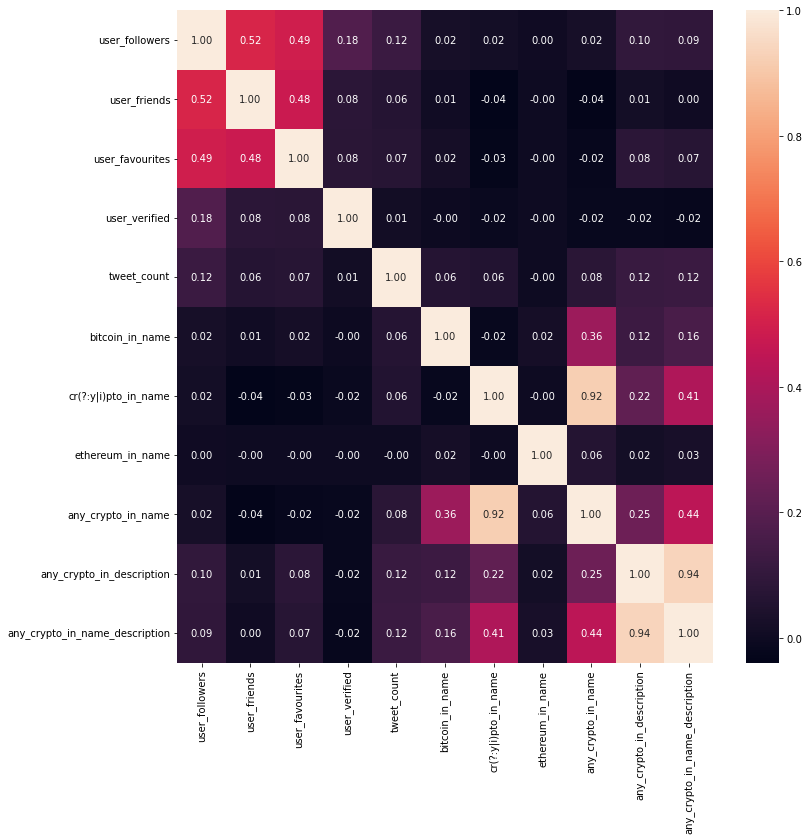

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,12))
sns.heatmap(df3.corr(), annot=True, fmt='.2f')

- Como era de se esperar, as variáveis user_followers, user_favourites e user_friends têm alta correlação entre si.
- Também era de se esperar a correlação encontrada entre a coluna user_followers e as colunas user_verified e tweet_count. (usuário com mais seguidors têm maior chance de serem verificados e tweetam mais)
- As colunas criadas a partir de palavras-chaves também mostram uma correlação relevante
- A coluna tweet_count também mostra relação com o aparecimento de palavras-chave no nome e na descrição. Isso indica que os usuários que colocam essa palavra-chave costumam tweetar mais sobre o assunto

## Conclusões

A partir da análise, pode-se tirar algumas conclusões sobre os usuários:


- Não há uma grande representação de usuários verificados (<1%). Talvez essa proporção seja maior do que a geral no twitter, mas essa informação não está no dataset
- A maioria dos usuários que tweeta sobre bitcoin teve a conta criada entre 2019 e 2022. Há um aumento significativo a partir de 2020
- Boa parte dos tweets vêm de plataformas móveis (Android e Apple), o que indica que os usuário usam bastante o celular para tweetar sobre bitcoin
- Os usuários têm média de 5226 favoritos, com mediana 586. Os usuários têm média de 732 amigos, com mediana 236. Os usuários têm média de 2926 seguidores, com mediana 76. São três distribuições com relevante assimetria positiva. Ou seja, uma minoria dos usuários têm números muito mais altos em relação ao restante, o que aumenta a média do dataset.
- 30% dos usuários tem alguma palavra chave relacionada a criptomoedas (bitcoin, crypto, ehereum) em sua descrição ou em seu nome. Isso indica que os tweets sobre o assunto são feitos, em boa parte, por usuário com relação próxima ao tema
- A mediana de postagens por usuário é apenas 1, ou seja, pelo menos metade dos usuários do dataset têm apenas uma postagem sobre o assunto. Essa informação nos indica que há também um grande número de usuários que fala sobre bitcoin de maneira mais casual
- Uma parte relavante dos usuários que tweetaram sobre bitcoin está concentrada em três clusters geográficos: Estados Unidos, Europa Ocidental e Índia (com Paquistão e Bangladesh)
- Usuários com mais seguidores têm também mais amigos e mais favoritos. E isso vale pra comparação de qualquer uma dessas 3 característica em relação às outras duas.
- Usuário com mais seguidores têm maior probabilidade de serem verificados e têm mais tweets
- O número de tweets mostrou relação relavante com a presença de palavras-chave cripto no nome ou na descrição. Isso indica que os usuários que usam essas palavras em ser perfil tweetam mais sobre o assunto